# Menú - Detección de Fases Respiratorias

In [ ]:
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- CONSTANTES DE CONFIGURACIÓN ---
RUTA_BUSQUEDA_AUDIO = "/content/drive/MyDrive/Mindfulness/data_test2" # Ruta archivos de audio
FACTOR_UMBRAL_APNEA = 0.1   # Porcentaje de la amplitud máxima para considerar apnea

def calcular_envolvente_amplitud(y, sr):
    segundos_completos = int(len(y) / sr)
    y_truncado = y[:segundos_completos * sr]
    segmentos = y_truncado.reshape((segundos_completos, sr))
    media_pos = np.mean(segmentos, axis=1, where=(segmentos > 0))
    media_neg = np.mean(segmentos, axis=1, where=(segmentos < 0))
    tiempo = np.arange(segundos_completos)
    return pd.DataFrame({'Tiempo': tiempo, 'Media_Positiva': media_pos, 'Media_Negativa': media_neg})

def identificar_intervalos_fases(apnea_mask, tiempo):
    detalles = {'inhalacion': [], 'exhalacion': [], 'apnea': []}
    cambios = np.diff(apnea_mask.astype(int), prepend=apnea_mask.iloc[0])
    puntos_de_cambio_idx = np.where(cambios != 0)[0]
    inicio_idx = 0
    alternador_respiracion = True
    for fin_idx in puntos_de_cambio_idx:
        if fin_idx == 0: continue
        es_apnea = apnea_mask[inicio_idx]
        inicio_tiempo = tiempo[inicio_idx]
        fin_tiempo = tiempo[fin_idx - 1]
        if fin_tiempo >= inicio_tiempo:
            if es_apnea:
                detalles['apnea'].append([inicio_tiempo, fin_tiempo])
            else:
                if alternador_respiracion:
                    detalles['inhalacion'].append([inicio_tiempo, fin_tiempo])
                else:
                    detalles['exhalacion'].append([inicio_tiempo, fin_tiempo])
                alternador_respiracion = not alternador_respiracion
        inicio_idx = fin_idx
    if inicio_idx < len(apnea_mask):
        es_apnea = apnea_mask[inicio_idx]
        inicio_tiempo = tiempo[inicio_idx]
        fin_tiempo = tiempo.iloc[-1]
        if fin_tiempo >= inicio_tiempo:
            if es_apnea:
                detalles['apnea'].append([inicio_tiempo, fin_tiempo])
            else:
                if alternador_respiracion:
                    detalles['inhalacion'].append([inicio_tiempo, fin_tiempo])
                else:
                    detalles['exhalacion'].append([inicio_tiempo, fin_tiempo])
    return detalles

def construir_tabla_ciclos_respiratorios(fases):
    eventos = fases_a_eventos(fases)
    ciclos_data = []
    i = 0
    while i <= len(eventos) - 4:
        e1, e2, e3, e4 = eventos[i:i+4]
        if e1[2] == 'inhalacion' and e2[2] == 'apnea' and e3[2] == 'exhalacion' and e4[2] == 'apnea':
            ciclo_actual = {
                'Ciclo': len(ciclos_data) + 1,
                'Inhalacion (s)': e1[1] - e1[0] + 1,
                'Apnea 1 (s)': e2[1] - e2[0] + 1,
                'Exhalacion (s)': e3[1] - e3[0] + 1,
                'Apnea 2 (s)': e4[1] - e4[0] + 1
            }
            ciclo_actual['Total Ciclo (s)'] = sum(list(ciclo_actual.values())[1:])
            ciclos_data.append(ciclo_actual)
            i += 4
        else:
            i += 1
    if not ciclos_data:
        return pd.DataFrame(columns=['Ciclo', 'Inhalacion (s)', 'Apnea 1 (s)', 'Exhalacion (s)', 'Apnea 2 (s)', 'Total Ciclo (s)'])
    df_ciclos = pd.DataFrame(ciclos_data)
    promedios = df_ciclos.drop(columns='Ciclo').mean().round(1)
    promedios['Ciclo'] = 'avg'
    df_ciclos = pd.concat([df_ciclos, pd.DataFrame([promedios])], ignore_index=True)
    return df_ciclos

def visualizar_grafico(y, sr, df_envolvente, fases, guardar=False, mostrar_espectrograma=False, ruta_guardado=None):
    num_plots = 3 if mostrar_espectrograma else 2
    fig_height = 12 if mostrar_espectrograma else 9
    fig, axs = plt.subplots(num_plots, 1, figsize=(16, fig_height), sharex=True)
    if num_plots == 1: axs = [axs]

    # Gráfico 1: Señal de Audio Original
    ax_signal = axs[0]
    librosa.display.waveshow(y, sr=sr, ax=ax_signal, color='gray')
    ax_signal.set_title('Señal de Audio Original')
    ax_signal.set_ylabel('Amplitud')

    # Gráfico 2: Detección de Fases Respiratorias
    ax_phases = axs[1]
    ax_phases.plot(df_envolvente['Tiempo'], df_envolvente['Media_Positiva'], label='Media Positiva', color='blue', alpha=0.6)
    ax_phases.plot(df_envolvente['Tiempo'], df_envolvente['Media_Negativa'], label='Media Negativa', color='purple', alpha=0.4)

    eventos = fases_a_eventos(fases)
    fase_info = {
        'inhalacion': {'color': 'green', 'label': 'Inhalación'},
        'exhalacion': {'color': 'gold', 'label': 'Exhalación'},
        'apnea': {'color': 'red', 'label': 'Apnea'}
    }
    leyendas_añadidas = set()
    y_max_envolvente = df_envolvente['Media_Positiva'].dropna().max()
    if pd.isna(y_max_envolvente) or y_max_envolvente == 0: y_max_envolvente = 0.01

    # Ajuste de la posición del texto del ciclo para evitar solapamiento
    pos_y_texto = y_max_envolvente * 0.9  # Se reduce la altura para alejarlo del título

    for i, (start, end, tipo) in enumerate(eventos):
        info = fase_info[tipo]
        label = info['label'] if tipo not in leyendas_añadidas else ""
        ax_phases.axvspan(start - 0.5, end + 0.5, color=info['color'], alpha=0.3, label=label)
        leyendas_añadidas.add(tipo)
        if i % 4 == 0:
            ciclo_num = (i // 4) + 1
            ax_phases.text(start, pos_y_texto, str(ciclo_num), fontsize=9, va='bottom', ha='center', color='black', fontweight='bold')

    # Aumentar el límite del eje Y para dar más espacio al título
    ax_phases.set_ylim(top=y_max_envolvente * 1.2)

    ax_phases.set_ylabel('Amplitud Media')
    ax_phases.set_title('Detección de Fases Respiratorias')
    ax_phases.legend(loc='lower right')
    ax_phases.grid(True, linestyle='--', alpha=0.6)

    # Gráfico 3: Espectrograma (si se solicita)
    if mostrar_espectrograma:
        ax_spec = axs[2]
        S_db = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', ax=ax_spec)
        ax_spec.set_title('Espectrograma')
        ax_spec.set_ylabel('Frecuencia (Hz)')

    # Configuración final del eje X para todos los subgráficos
    max_tiempo = df_envolvente['Tiempo'].max()
    if max_tiempo > 0:
        tick_step = 5 if len(df_envolvente['Tiempo']) > 60 else 1
        ticks = np.arange(0, max_tiempo + 1, tick_step)

        for ax in axs:
            ax.set_xlabel('Tiempo (s)')
            ax.tick_params(axis='x', labelrotation=45, which='both', labelbottom=True)
            ax.set_xticks(ticks)

    plt.tight_layout()

    if guardar and ruta_guardado:
        plt.savefig(ruta_guardado, dpi=300, bbox_inches='tight')
        print(f"Gráfico guardado en: {ruta_guardado}")

    plt.show()

def fases_a_eventos(fases):
    eventos = []
    for tipo, intervalos in fases.items():
        for inicio, fin in intervalos:
            eventos.append([inicio, fin, tipo])
    eventos.sort()
    return eventos

def eventos_a_fases(eventos):
    fases = {'inhalacion': [], 'exhalacion': [], 'apnea': []}
    for inicio, fin, tipo in eventos:
        if tipo in fases:
            fases[tipo].append([inicio, fin])
    return fases

def ejecutar_analisis_preliminar():
    try:
        wav_files = [f for f in os.listdir(RUTA_BUSQUEDA_AUDIO) if f.lower().endswith('.wav')]
        if not wav_files:
            print(f"Error: No se encontraron archivos .wav en '{RUTA_BUSQUEDA_AUDIO}'.")
            return None, None, None, None, None, None, None

        print("\n--- Seleccione un archivo de audio ---")
        for i, filename in enumerate(wav_files):
            print(f"[{i+1}] {filename}")

        file_choice = input("Ingrese el número del archivo: ")
        idx = int(file_choice) - 1
        if not 0 <= idx < len(wav_files):
            print("Error: Selección no válida.")
            return None, None, None, None, None, None, None

        nombre_audio = wav_files[idx]
        ruta_audio_input = os.path.join(RUTA_BUSQUEDA_AUDIO, nombre_audio)

    except (ValueError, IndexError):
        print("Error: Entrada no válida.")
        return None, None, None, None, None, None, None
    except FileNotFoundError:
        print(f"Error: El directorio de búsqueda '{RUTA_BUSQUEDA_AUDIO}' no fue encontrado.")
        return None, None, None, None, None, None, None

    ruta_principal = os.path.dirname(ruta_audio_input)
    y, sr = librosa.load(ruta_audio_input, sr=None)
    print(f"Audio cargado: {nombre_audio}, Duración: {len(y)/sr:.2f}s, Tasa de muestreo: {sr} Hz")

    df_envolvente = calcular_envolvente_amplitud(y, sr)

    media_pos_max = df_envolvente['Media_Positiva'].dropna().max()
    media_neg_min = df_envolvente['Media_Negativa'].dropna().min()
    amplitud_max = max(media_pos_max if pd.notna(media_pos_max) else 0, abs(media_neg_min) if pd.notna(media_neg_min) else 0)
    umbral_apnea = amplitud_max * FACTOR_UMBRAL_APNEA

    apnea_mask = (df_envolvente['Media_Positiva'].fillna(0) < umbral_apnea) & \
                 (np.abs(df_envolvente['Media_Negativa'].fillna(0)) < umbral_apnea)

    fases_detectadas = identificar_intervalos_fases(apnea_mask, df_envolvente['Tiempo'])
    df_tabla = construir_tabla_ciclos_respiratorios(fases_detectadas)

    return y, sr, df_envolvente, fases_detectadas, df_tabla, nombre_audio, ruta_principal

def modificar_fases(fases_detectadas):
    if fases_detectadas is None:
        print("Error: Primero debe ejecutar el análisis preliminar (Opción 1).")
        return None, None

    eventos = fases_a_eventos(fases_detectadas)
    while True:
        print("\n--- Modificación de Fases ---")

        ciclo_num = 1
        # Imprime un encabezado para las fases que puedan existir antes de la primera inhalación.
        if eventos and eventos[0][2] != 'inhalacion':
            print("--- Fases iniciales (sin ciclo) ---")

        for i, (inicio, fin, tipo) in enumerate(eventos):
            # Cada vez que aparece una inhalación, se asume un nuevo ciclo.
            if tipo == 'inhalacion':
                print(f"\n--- Ciclo {ciclo_num} ---")
                ciclo_num += 1

            print(f"[{i+1}] {tipo.capitalize()} ({inicio}s - {fin}s)")

        sub_opcion = input("\nIngrese el número de la fase a modificar, 'r' para recalcular, o 'v' para volver al menú principal: ")
        if sub_opcion.lower() == 'v':
            break
        if sub_opcion.lower() == 'r':
            fases_detectadas = eventos_a_fases(eventos)
            df_tabla = construir_tabla_ciclos_respiratorios(fases_detectadas)
            print("\n--- Tabla de Ciclos Recalculada ---")
            print(df_tabla.to_string(index=False))
            continue

        try:
            idx = int(sub_opcion) - 1
            if not 0 <= idx < len(eventos):
                raise ValueError
        except ValueError:
            print("Error: Entrada no válida.")
            continue

        print(f"Fase seleccionada: [{idx+1}] {eventos[idx][2].capitalize()}")
        accion = input("Qué desea hacer? (T = Cambiar Tipo, D = Eliminar): ").lower()

        if accion == 'd':
            del eventos[idx]
            print("Fase eliminada.")
        elif accion == 't':
            nuevo_tipo = input("Ingrese nuevo tipo (I=inhalacion, E=exhalacion, A=apnea): ").lower()
            mapa_tipos = {'i': 'inhalacion', 'e': 'exhalacion', 'a': 'apnea'}
            if nuevo_tipo in mapa_tipos:
                eventos[idx][2] = mapa_tipos[nuevo_tipo]
                print("Tipo de fase cambiado.")
            else:
                print("Error: Tipo no válido.")
                continue
        else:
            print("Error: Acción no válida.")
            continue

        alternador = True
        for i in range(idx - 1, -1, -1):
            if eventos[i][2] == 'inhalacion':
                alternador = False
                break
            elif eventos[i][2] == 'exhalacion':
                alternador = True
                break

        for i in range(idx, len(eventos)):
            if eventos[i][2] != 'apnea':
                eventos[i][2] = 'inhalacion' if alternador else 'exhalacion'
                alternador = not alternador

        print("Fases subsiguientes re-etiquetadas automáticamente.")

        fases_detectadas = eventos_a_fases(eventos)
        df_tabla = construir_tabla_ciclos_respiratorios(fases_detectadas)
        print("\n--- Tabla de Ciclos Actualizada ---")
        print(df_tabla.to_string(index=False))

    return fases_detectadas, construir_tabla_ciclos_respiratorios(fases_detectadas)

def guardar_resultados(y, sr, df_envolvente, fases_detectadas, df_tabla, nombre_audio, ruta_principal):
    if df_tabla is None or y is None:
        print("Error: Primero debe ejecutar el análisis (Opción 1).")
        return

    print("Guardando resultados...")
    base_nombre_archivo = os.path.splitext(nombre_audio)[0]
    ruta_grafico = os.path.join(ruta_principal, f"{base_nombre_archivo}_analisis_corregido.png")
    ruta_excel = os.path.join(ruta_principal, f"{base_nombre_archivo}_ciclos_corregidos.xlsx")

    visualizar_grafico(y, sr, df_envolvente, fases_detectadas, guardar=True, mostrar_espectrograma=True, ruta_guardado=ruta_grafico)
    df_tabla.to_excel(ruta_excel, index=False)
    print(f"Tabla guardada en: {ruta_excel}")

## Opción 1. Análisis preliminar

In [ ]:
datos_analisis = {
        "y": None, "sr": None, "df_envolvente": None,
        "fases_detectadas": None, "df_tabla": None,
        "nombre_audio": None, "ruta_principal": None
    }

y, sr, df_envolvente, fases, tabla, nombre, ruta = ejecutar_analisis_preliminar()
if y is not None:
    datos_analisis.update({
        "y": y, "sr": sr, "df_envolvente": df_envolvente,
        "fases_detectadas": fases, "df_tabla": tabla,
        "nombre_audio": nombre, "ruta_principal": ruta
    })


--- Seleccione un archivo de audio ---
[1] 10-junio-4.14-am.wav
[2] 12-junio-2024-16_11.wav
[3] 14-junio-2024-04_07-am.wav
[4] 24.6.2025-15.58pm.wav
Ingrese el número del archivo: 2
Audio cargado: 12-junio-2024-16_11.wav, Duración: 608.50s, Tasa de muestreo: 44100 Hz


## Opción 2. Gráfica y modificación

2.1 Gráfica

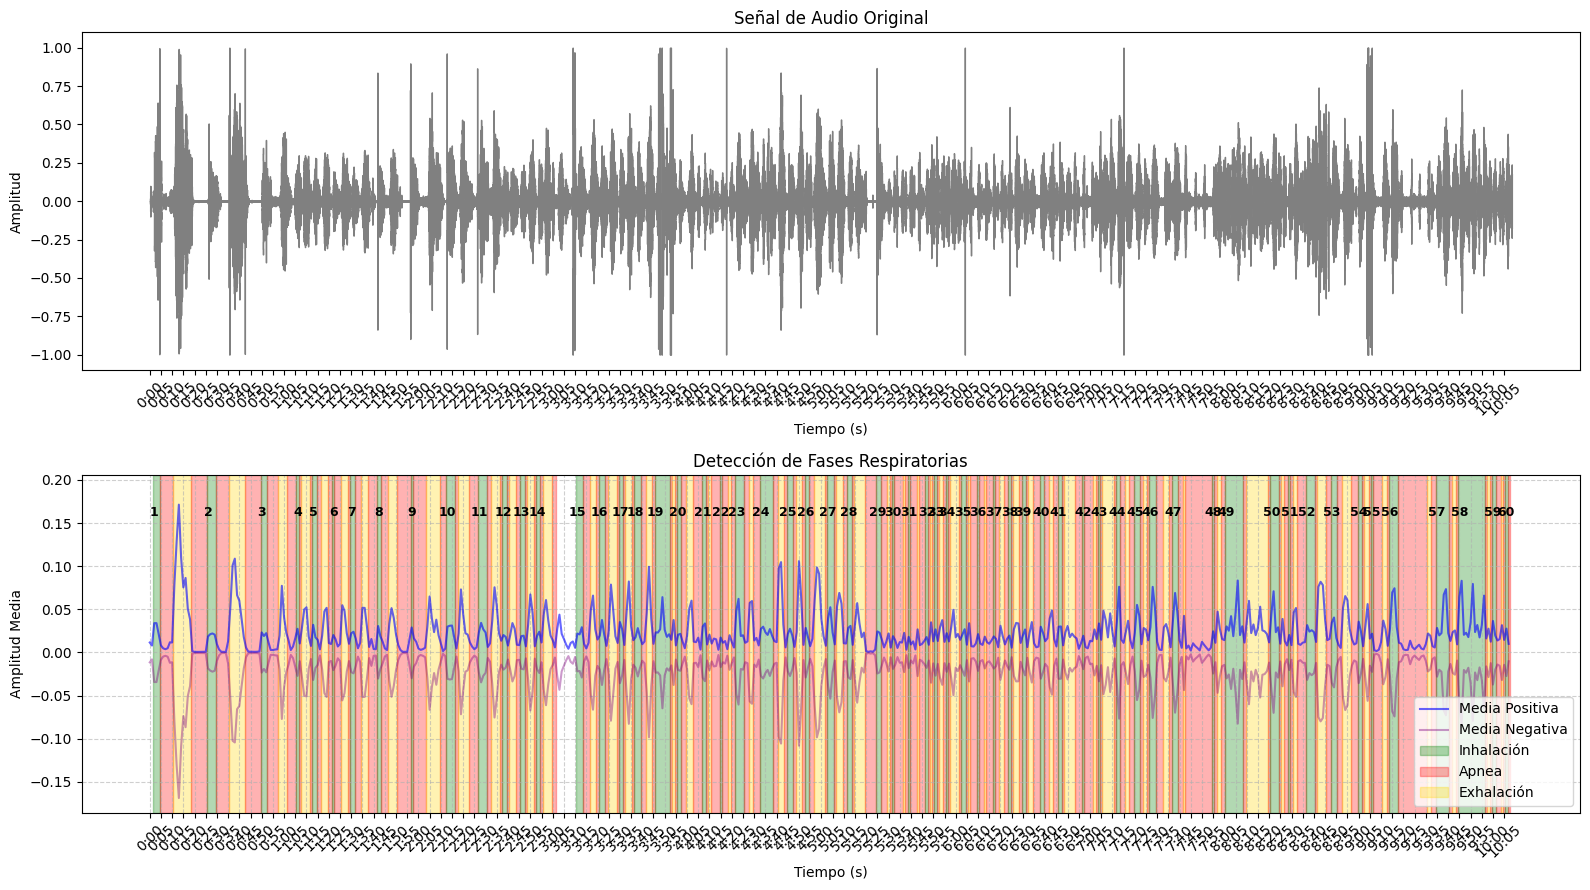

In [ ]:
visualizar_grafico(y, sr, df_envolvente, fases, guardar=False, mostrar_espectrograma=False)

2.2 Modificación

In [ ]:
fases, tabla = modificar_fases(datos_analisis["fases_detectadas"])
if fases is not None:
    datos_analisis["fases_detectadas"] = fases
    datos_analisis["df_tabla"] = tabla


--- Modificación de Fases ---

--- Ciclo 1 ---
[1] Inhalacion (2s - 4s)
[2] Apnea (5s - 10s)
[3] Exhalacion (11s - 18s)
[4] Apnea (19s - 25s)

--- Ciclo 2 ---
[5] Inhalacion (26s - 29s)
[6] Apnea (30s - 35s)
[7] Exhalacion (36s - 42s)
[8] Apnea (43s - 49s)

--- Ciclo 3 ---
[9] Inhalacion (50s - 52s)
[10] Apnea (53s - 57s)
[11] Exhalacion (58s - 61s)
[12] Apnea (62s - 65s)

--- Ciclo 4 ---
[13] Inhalacion (66s - 66s)
[14] Apnea (67s - 67s)
[15] Exhalacion (68s - 71s)
[16] Apnea (72s - 72s)

--- Ciclo 5 ---
[17] Inhalacion (73s - 74s)
[18] Apnea (75s - 76s)
[19] Exhalacion (77s - 79s)
[20] Apnea (80s - 81s)

--- Ciclo 6 ---
[21] Inhalacion (82s - 82s)
[22] Apnea (83s - 85s)
[23] Exhalacion (86s - 88s)
[24] Apnea (89s - 89s)

--- Ciclo 7 ---
[25] Inhalacion (90s - 91s)
[26] Apnea (92s - 94s)
[27] Exhalacion (95s - 97s)
[28] Apnea (98s - 101s)

--- Ciclo 8 ---
[29] Inhalacion (102s - 103s)
[30] Apnea (104s - 106s)
[31] Exhalacion (107s - 110s)
[32] Apnea (111s - 116s)

--- Ciclo 9 ---
[33

## Opción 3. Guardar resultados (Gráfico y Tabla)

Guardando resultados...
Gráfico guardado en: /content/drive/MyDrive/Mindfulness/data_test2/12-junio-2024-16_11_analisis_corregido.png


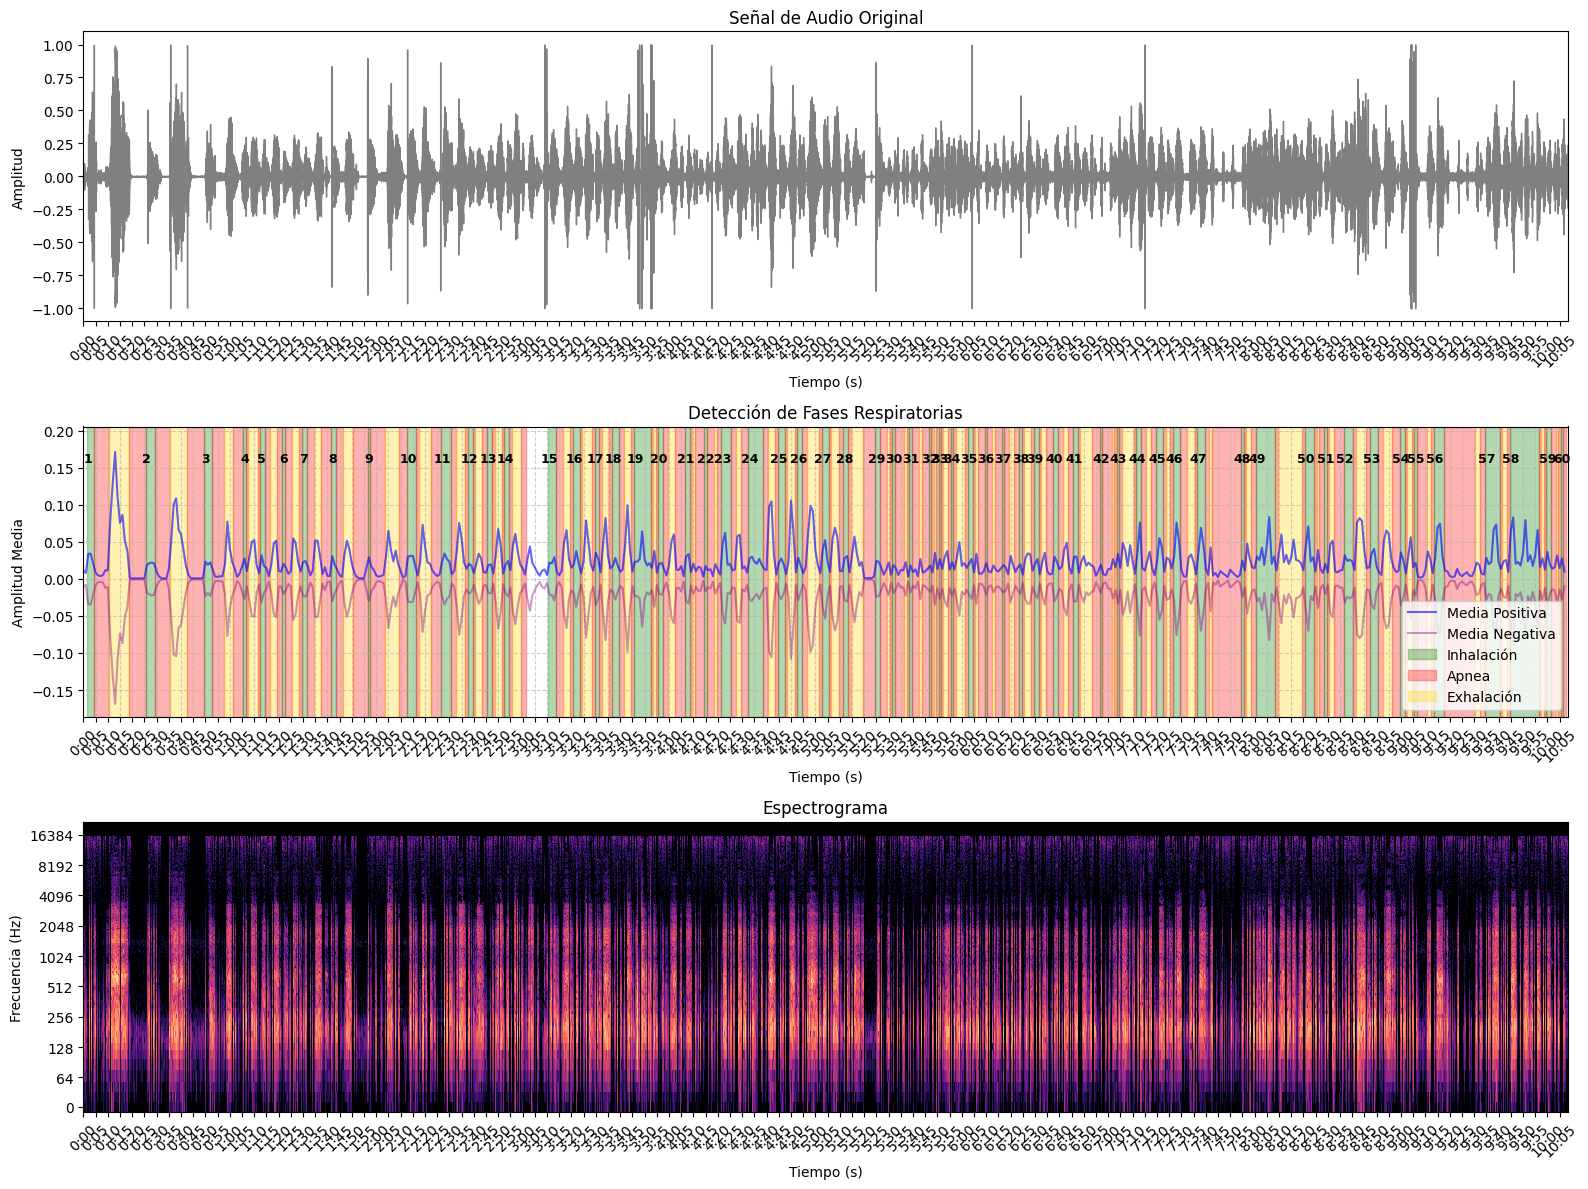

Tabla guardada en: /content/drive/MyDrive/Mindfulness/data_test2/12-junio-2024-16_11_ciclos_corregidos.xlsx


In [ ]:
guardar_resultados(**datos_analisis)

# Análisis de Respiración

In [ ]:
import pandas as pd
import numpy as np
import os

# --- FUNCIONES DE CÁLCULO DE SCORES ---

def calcular_score_profundidad(df):
    media_ciclo = df['Total Ciclo (s)'].mean()
    score = min(1.0, media_ciclo / CONFIG["T_OBJETIVO"]) * 100
    return score

def calcular_score_estabilidad(df):
    scores_estabilidad = {}
    pesos = CONFIG["W_ESTABILIDAD_FASICA"]

    for fase, col_name in zip(pesos.keys(), COLUMNAS_FASES):
        media = df[col_name].mean()
        desv_est = df[col_name].std()
        cv = (desv_est / media) if media > 0 else 0
        scores_estabilidad[fase] = max(0, 1 - cv) * 100

    score_final_ponderado = sum(pesos[fase] * scores_estabilidad[fase] for fase in pesos)
    return score_final_ponderado

def calcular_score_balance(df):
    pesos = CONFIG["W_BALANCE_INTERNO"]

    media_inh = df['Inhalacion (s)'].mean()
    media_exh = df['Exhalacion (s)'].mean()
    r_actual = (media_exh / media_inh) if media_inh > 0 else 0
    s_ratio = max(0, 1 - abs(r_actual - CONFIG["R_OBJETIVO"]) / CONFIG["R_OBJETIVO"]) * 100

    media_ap1 = df['Apnea 1 (s)'].mean()
    media_ap2 = df['Apnea 2 (s)'].mean()
    media_ciclo = df['Total Ciclo (s)'].mean()
    p_apnea_actual = ((media_ap1 + media_ap2) / media_ciclo) if media_ciclo > 0 else 0
    s_control_apnea = max(0, 1 - abs(p_apnea_actual - CONFIG["P_OBJETIVO"]) / CONFIG["P_OBJETIVO"]) * 100

    score_final_ponderado = (pesos['ratio_ie'] * s_ratio + pesos['control_apnea'] * s_control_apnea)
    return score_final_ponderado

# --- FUNCIONES DE ORQUESTACIÓN Y UTILIDAD ---

def seleccionar_archivo_excel(ruta_base):
    """Busca archivos .xlsx en la ruta_base, los lista y pide al usuario que elija uno."""
    try:
        archivos_xlsx = [f for f in os.listdir(ruta_base) if f.lower().endswith('.xlsx')]
        if not archivos_xlsx:
            print(f"No se encontraron archivos .xlsx en el directorio: {ruta_base}")
            return None

        print("\n--- Seleccione un archivo para analizar ---")
        for i, filename in enumerate(archivos_xlsx):
            print(f"[{i+1}] {filename}")

        while True:
            try:
                choice = int(input("Ingrese el número del archivo: ")) - 1
                if 0 <= choice < len(archivos_xlsx):
                    return os.path.join(ruta_base, archivos_xlsx[choice])
                else:
                    print("Error: Selección fuera de rango.")
            except ValueError:
                print("Error: Por favor, ingrese solo un número.")

    except FileNotFoundError:
        print(f"Error: El directorio base no fue encontrado: {ruta_base}")
        return None

def cargar_y_preparar_datos(file_path):
    df = pd.read_excel(file_path)
    df.columns = df.columns.str.strip()

    if 'Total Ciclo (s)' not in df.columns:
        df['Total Ciclo (s)'] = df[COLUMNAS_FASES].sum(axis=1)

    if 'Ciclo' in df.columns and 'avg' in df['Ciclo'].values:
        df = df[df['Ciclo'] != 'avg'].copy()

    return df

def generar_reporte(scores, num_ciclos):
    print("\n--- ANÁLISIS DEL SCORE DE COHERENCIA RESPIRATORIA ---")
    print(f"Basado en {num_ciclos} ciclos respiratorios.")
    print("-" * 50)
    print("PILARES INDIVIDUALES:")
    print(f"➤ Score de Profundidad:   {scores['Profundidad']:>6.2f} / 100")
    print(f"➤ Score de Estabilidad:   {scores['Estabilidad']:>6.2f} / 100")
    print(f"➤ Score de Balance Interno: {scores['Balance Interno']:>6.2f} / 100")
    print("-" * 50)
    print(f"📊 SCORE FINAL:   {scores['Final']:>6.2f} / 100")
    print("-" * 50)

    pilar_mas_debil = min({k: v for k, v in scores.items() if k != 'Final'}, key=scores.get)
    print("DIAGNÓSTICO RÁPIDO:")
    print(f"El pilar con mayor área de mejora es: **{pilar_mas_debil}**.")
    if pilar_mas_debil == 'Profundidad':
        print("Recomendación: Intenta respirar de manera más lenta y profunda.")
    elif pilar_mas_debil == 'Estabilidad':
        print("Recomendación: Concéntrate en mantener un ritmo constante en cada fase.")
    else:
        print("Recomendación: Trabaja en la estructura de tu respiración (ej. exhalación más larga).")

def ejecutar_analisis(file_path):
    try:
        df = cargar_y_preparar_datos(file_path)
        print(f"\n✅ Archivo '{os.path.basename(file_path)}' cargado. Analizando {len(df)} ciclos.")
        display(df)

        s_profundidad = calcular_score_profundidad(df)
        s_estabilidad = calcular_score_estabilidad(df)
        s_balance = calcular_score_balance(df)

        w = CONFIG["W_PILARES"]
        score_final = (w['profundidad'] * s_profundidad +
                       w['estabilidad'] * s_estabilidad +
                       w['balance'] * s_balance)

        scores = {
            'Profundidad': s_profundidad,
            'Estabilidad': s_estabilidad,
            'Balance Interno': s_balance,
            'Final': score_final
        }

        generar_reporte(scores, len(df))

    except Exception as e:
        print(f"❌ Ocurrió un error inesperado durante el análisis: {e}")

In [ ]:
# --- CONFIGURACIÓN GLOBAL DEL ANÁLISIS ---
CONFIG = {
    # Pilar de Profundidad: Objetivo de duración del ciclo en segundos.
    "T_OBJETIVO": 20.0,  # 12s = 5 RPM, 20s = 3 RPM

    # Pilar de Balance Interno: Objetivos de estructura respiratoria.
    "R_OBJETIVO": 1.5,   # Ratio Exhalación / Inhalación
    "P_OBJETIVO": 0.2,   # Porcentaje del ciclo dedicado a apneas

    # Ponderación de los Pilares Principales (debe sumar 1.0)
    "W_PILARES": {
        "profundidad": 0.3,
        "estabilidad": 0.4,
        "balance": 0.3
    },

    # Ponderación Interna para Estabilidad (debe sumar 1.0)
    "W_ESTABILIDAD_FASICA": {
        'inh': 0.40, 'exh': 0.40, 'ap1': 0.10, 'ap2': 0.10
    },

    # Ponderación Interna para Balance (debe sumar 1.0)
    "W_BALANCE_INTERNO": {
        'ratio_ie': 0.7, 'control_apnea': 0.3
    }
}

COLUMNAS_FASES = ['Inhalacion (s)', 'Apnea 1 (s)', 'Exhalacion (s)', 'Apnea 2 (s)']

# Define el directorio donde se buscarán los archivos Excel.
RUTA_BUSQUEDA_DATA = "/content/drive/MyDrive/Mindfulness/data_test2" # Ruta archivos de audio

ruta_archivo_seleccionado = seleccionar_archivo_excel(RUTA_BUSQUEDA_DATA)

ejecutar_analisis(ruta_archivo_seleccionado)


--- Seleccione un archivo para analizar ---
[1] 10-junio-4.14-am_ciclos_corregidos.xlsx
[2] 14-junio-2024-04_07-am_ciclos_corregidos.xlsx
[3] 24.6.2025-15.58pm_ciclos_corregidos.xlsx
[4] 12-junio-2024-16_11_ciclos_corregidos.xlsx
Ingrese el número del archivo: 4

✅ Archivo '12-junio-2024-16_11_ciclos_corregidos.xlsx' cargado. Analizando 59 ciclos.


,Ciclo,Inhalacion (s),Apnea 1 (s),Exhalacion (s),Apnea 2 (s),Total Ciclo (s)
0,1,3.0,6.0,8.0,7.0,24.0
1,2,4.0,6.0,7.0,7.0,24.0
2,3,3.0,5.0,4.0,4.0,16.0
3,4,1.0,1.0,4.0,1.0,7.0
4,5,2.0,2.0,3.0,2.0,9.0
5,6,1.0,3.0,3.0,1.0,8.0
6,7,2.0,3.0,3.0,4.0,12.0
7,8,2.0,3.0,4.0,6.0,15.0
8,9,1.0,6.0,6.0,3.0,16.0
9,10,4.0,1.0,5.0,4.0,14.0



--- ANÁLISIS DEL SCORE DE COHERENCIA RESPIRATORIA ---
Basado en 59 ciclos respiratorios.
--------------------------------------------------
PILARES INDIVIDUALES:
➤ Score de Profundidad:    50.42 / 100
➤ Score de Estabilidad:    19.13 / 100
➤ Score de Balance Interno:  52.39 / 100
--------------------------------------------------
📊 SCORE FINAL:    38.49 / 100
--------------------------------------------------
DIAGNÓSTICO RÁPIDO:
El pilar con mayor área de mejora es: **Estabilidad**.
Recomendación: Concéntrate en mantener un ritmo constante en cada fase.
